# Machine Learning Foundation

## Course 5, Part h: Autoencoders LAB

## Learning Objectives 

1. Implement the following dimensionality reduction techniques on the MNIST data:
    * PCA
    * Autoencoders
    * Variational autoencoders
2. Use appropriate scoring metrics to compare the performance of each.

## MNIST data

Throughout this lesson, we'll be working with the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains 70,000 handwritten black-and-white images, which are traditionally split into 60k training images and 10k validation images.

In [1]:
from tensorflow.keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data();

In [2]:
x_train.shape

(60000, 28, 28)

In [3]:
x_test.shape

(10000, 28, 28)

### Preprocess MNIST

We'll preprocess by scaling images pixels to be between 0 and 1.

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### Part 1: PCA

We'll use PCA as a baseline with which we can compare our deep learning models.

For PCA we'll treat each image like a "row" of data and flatten our data, so each observation is 784 columns:

In [5]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))) # make it two dimensional array
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


Recall that PCA will do a **matrix decomposition** of this data to find the **eigenvalues** - these **eigenvalues** will be the **principal components** of the data, or the "latent features" that describe a maximal amount of variance in the data.

PCA works better if our features are scaled, so let's do that. 

In [6]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [7]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)

    fit_pca = pca.fit(x_data)
    
    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2)) # Printing the explained variance = 1

    return fit_pca, fit_pca.transform(x_data)

In [8]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


In [9]:
pca_full # PCA object

PCA(n_components=784)

In [10]:
mnist_data_full.shape  # Transformed opbject

(60000, 784)

In [11]:
len(pca_full.explained_variance_ratio_) # How much each feature explained

784

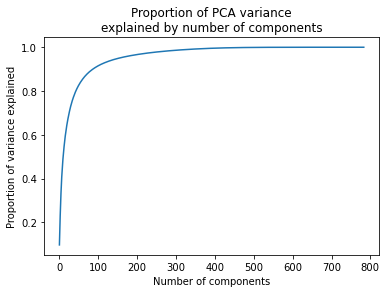

In [12]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)) # Return the cumulative sum of the elements along a given axis.
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

We need about 250 components to explain 90% of the variance in the data!

For visualization purposes, let's extract just two components and plot them:

In [13]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.17


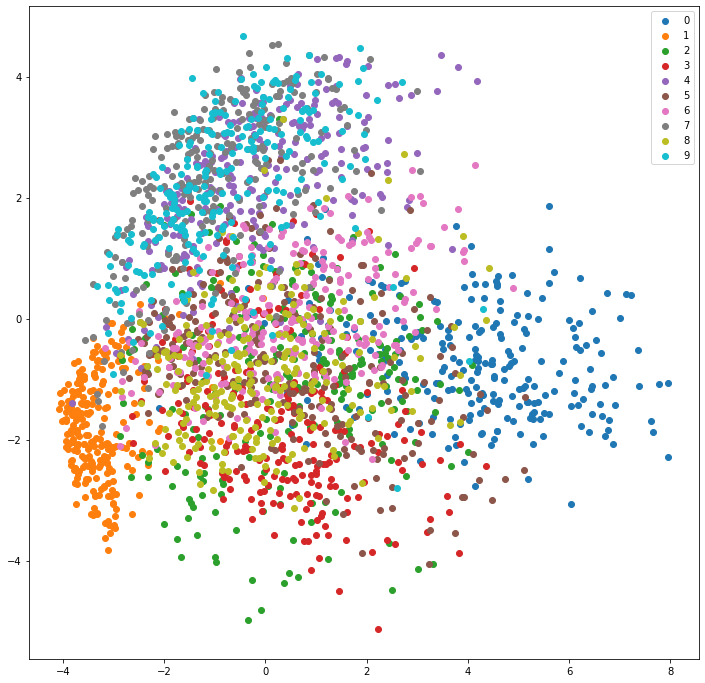

In [14]:
num_images_per_class = 250
fig = plt.figure(figsize=(12,12))
for number in list(range(10)): # from 0 to 10
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class] # We only want the rows that is MASK = TRUE for the first column.
    y_data = mnist_data_2[mask, 1][:num_images_per_class] # We only want the rows that is MASK + TRUE for the second column.
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend();

We can already see that the latent features PCA is learning _somewhat_ disentangle the features here, and a neural network could certainly help with this.

### Scoring PCA

What we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?

As with all models, we should test performance on a different dataset than we trained on:

In [15]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.86


In [16]:
x_test_scaled = s.transform(x_test_flat) # transform only

In [17]:
x_test_flat_64 = pca_64.transform(x_test_scaled) # using the object created with training to transofrm the test set
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64) # Returning to the original shape

In [18]:
x_test_flat_64.shape

(10000, 64)

In [19]:
x_test_reconstructed_64.shape

(10000, 784)

In [20]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [21]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [22]:
mse_reconstruction(true, reconstructed)

90.55158

Average MSE of **90.6**, using 64 components, for PCA.

### Simple AE

Now let's build an autoencoder! Fundamentally, an autoencoder is an **neural network where the input is the same as the output.** The hope for such networks is that one of the hidden layers will "learn a compressed representation" of the data, similar to the way PCA does.

In [23]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In practice, when implementing autoencoders using `Keras`, we define _three_ models:

* The "full autoencoder", here `full_model`, will take inputs and try to reconstruct them
* The "encoder", here `encoder_model`, will take inputs and try to reconstruct them
* The "decoder", here `decoder_model`, will take the latent space and try to reconstruct it

In [24]:
# This time we will be using the functional API instead of the sequential API

ENCODING_DIM = 64 # No. of nodes.

# Encoder model
inputs = Input(shape=(784,)) # Creating a blank tensor [Tensor is an array with a certain amount of dimensions]
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs) # The dense layer here is composed of 64 nodes
encoder_model = Model(inputs, encoded, name='encoder') # model 1 [inputs and outputs]

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding') # entering from 64 nodes
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs) # reconstruct features
decoder_model = Model(encoded_inputs, reconstruction, name='decoder') # Model 2 21

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

2022-08-07 05:35:15.836703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [26]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32) # Notice that input and output are the same

1875/1875 [==============================] - 9s 5ms/step - loss: 0.2102 - accuracy: 0.0139


Feel free to do `.summary` and `visual` on this trained model now.

In [27]:
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                50240     
                                                                 
 decoder (Functional)        (None, 784)               50960     
                                                                 
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!

In [28]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 [==============================] - 1s 2ms/step


(10000, 64)

So, the "encoder model" has already been trained! For example, the encoding for the first image in the test dataset is:

In [29]:
encoded_images[0]

array([1.00e+00, 1.00e+00, 5.25e-01, 1.00e+00, 1.62e-01, 2.27e-02,
       9.97e-01, 1.00e+00, 1.00e+00, 9.08e-01, 1.00e+00, 9.97e-01,
       9.99e-01, 3.09e-02, 9.56e-01, 1.00e+00, 1.00e+00, 1.00e+00,
       9.88e-01, 2.14e-01, 1.00e+00, 4.54e-03, 1.00e+00, 3.05e-01,
       1.00e+00, 1.00e+00, 1.00e+00, 9.97e-01, 1.00e+00, 5.86e-01,
       3.25e-03, 5.76e-03, 1.00e+00, 1.00e+00, 7.90e-01, 1.00e+00,
       1.00e+00, 7.79e-03, 1.00e+00, 1.00e+00, 1.00e+00, 9.93e-01,
       1.00e+00, 1.32e-01, 3.99e-02, 4.50e-01, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 1.00e+00, 8.90e-05, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 7.48e-01, 1.00e+00, 1.00e+00, 1.00e+00,
       1.00e+00, 1.00e+00, 2.47e-01, 8.14e-01], dtype=float32)

As we can see, the `encoder_model` has been trained!

### Exercise 1 [ We are basically calculating the pixel-wise distance]

With PCA, we compared the pixel-wise difference between the reconstructed images and the original images to score how good the model was. 

Your task is now to do the same using the autoencoder. You'll have to think about what needs to get fed through the autoencoder to do this. Your steps are:

1. Use the trained autoencoder to generate reconstructed images.
2. Compute the pixel-wise distance between the reconstructed images and the original images. 

Is your result higher or lower than what you got with PCA?

In [30]:
### BEGIN SOLUTION
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

313/313 [==============================] - 1s 2ms/step


339.34198

Significantly worse!

### Exercise 2:

One of the reasons this model does worse than PCA is that is isn't a "Deep Learning" model. Go ahead and add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.

In [31]:
ENCODING_DIM = 64
HIDDEN_DIM = 256
### BEGIN SOLUTION
# Encoder model
inputs = Input(shape=(784,))  # What type of tensor we are trying to pass through 
encoder_hidden = Dense(HIDDEN_DIM, activation="relu")(inputs)
encoded = Dense(ENCODING_DIM, activation="sigmoid")(encoder_hidden) 
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [32]:
full_model.summary()

Model: "full_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 64)                217408    
                                                                 
 decoder (Functional)        (None, 784)               218128    
                                                                 
Total params: 435,536
Trainable params: 435,536
Non-trainable params: 0
_________________________________________________________________


In [33]:
full_model = Model(inputs=inputs, 
                   outputs=outputs)

full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [34]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1617 - accuracy: 0.0108
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1135 - accuracy: 0.0105
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1009 - accuracy: 0.0120
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0946 - accuracy: 0.0135
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0909 - accuracy: 0.0141


In [35]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)
### END SOLUTION

313/313 [==============================] - 1s 2ms/step


92.14551

Better than PCA!

### Exercise 3:

You've probably noticed we've only been training our model for one epoch. Let's test to see how our model's reconstruction loss decreases as we train it more. 

Write code that:

1. Trains the autoencoder for 5 epochs
2. Prints the reconstruction loss after each epoch

Does the reconstruction loss decrease after each epoch?

In [36]:
def train_ae_epochs(num_epochs=1): # one epoch unless specified otherwise
### BEGIN SOLUTION
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    # Encoder model
    inputs = Input(shape=(784,))  # What type of tensor we are trying to pass through 
    encoder_hidden = Dense(HIDDEN_DIM, activation="relu")(inputs)
    encoded = Dense(ENCODING_DIM, activation="sigmoid")(encoder_hidden) 
    encoder_model = Model(inputs, encoded, name='encoder')

    # Decoder model
    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')
    
    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
    
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))
### END SOLUTION       
    return mse_res


In [37]:
x_train_flat.shape

(60000, 784)

In [38]:
train_ae_epochs(10)

313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 1 is 189.83729553222656
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 2 is 134.65298461914062
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 3 is 105.26675415039062
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 4 is 92.60623168945312
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 5 is 87.2905502319336
313/313 [==============================] - 1s 4ms/step
Reconstruction loss after epoch 6 is 80.78854370117188
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 7 is 74.7859115600586
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 8 is 68.92752838134766
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 9 is 68.54216003417969
313/313 [

[189.8373,
 134.65298,
 105.266754,
 92.60623,
 87.29055,
 80.78854,
 74.78591,
 68.92753,
 68.54216,
 66.53752]

This is promising: even though the loss and accuracy don't appear to be changing much, as we train our autoencoder for longer, it does appear to be getting better and better at reconstructing the (unseen) test images.

### Variational autoencoder

VAEs are a way have neural networks learn representations of data, as with regular autoencoders. This time, however, the neural network will learn parameters of a normal distribution that will have observations drawn from it that will be transformed back into images. This results in two dimensional latent representation of the data once the variational autoencoder is trained, where one dimension represents the mean of the normal distribution and the other dimension represents the standard deviation.

At a high level, the actual steps of a VAE are:

1. The first neural network, the "encoder", predicts two vectors for each image, which will then be interpreted as means and standard deviations and transformed into a normal distribution.
3. The second neural network, the "decoder", takes the results of this operation and tries to reconstruct the original image.
4. The entire system is trained with backpropagation. At each iteration, _two_ losses are computed:
    * One loss simply penalizes the system for producing images that don't match the original images.
    * The other loss penalizes the encoder model for not correctly producing statistics from the image that match a standard normal distribution. 
   

The function below involves transforming the VAE encoder outputs into a normally distributed output. 

Recall that the VAE encoder generates vectors representing $\mu$ and $log(\sigma)$. These are then transformed into the generator input via 

$$ G_{in} = \mu + \sigma * \epsilon $$

where $ \epsilon $ ~ $ N(0, 1) $.

### Review of variational autoencoder loss:

**Part 1:**

We know Variational Autoencoders use the first part of their architecture - the encoder - to output zeros for the mean and zeros for the log variance (equal to a "real" variance of 1). 

We also know that the penalty for a given prediction of $\mu_{pred}$ and $log(\sigma)_{pred}$ is:

$$
\frac{1}{2} * (e^{log(\sigma)_{pred}} - (1 + log(\sigma)_{pred}) + (\mu_{pred})^2 )
$$

* **Note 1**: we predict $\log(\sigma)$ because predicting $\sigma$ directly could result in a negative value, and having a negative value for the variance of a distribution makes no sense.
* **Note 2**: the cost function has two components, both of which penalize us for having results that deviate from a standard normal distribution.
    * The first part penalizes the $log(\sigma)_{pred}$ from being away from 0, using the fact that $e^x - (x+1)$ is minimized at $x=0$.
    * The second part simply penalizes $\mu_{pred}$ from being away from 0.

This loss, representing a measure of the difference between these two distributions, is called the **KL Loss**.

**Part 2:**

The other part of the loss is simply the difference between the outputted image and the image fed in. The standard way of penalizing a difference between these two quantities is to use a `binary_crossentropy` function.

## Machine Learning Foundation (C) 2020 IBM Corporation